<a href="https://colab.research.google.com/github/lucywowen/csci547_ML/blob/main/examples/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

Ok so now that we've been introduced to the basics of clustering using K-means, and we've been introduced to density estimation from anomaly detection, let's expand on some of those ideas and add a few more.  Think of this is 'Clustering part 2'.  


As you go through the notebook I want you to think about these questions:

Questions to answer as you walk through the notebook:

 - What are the main differences between centroid, distribution, density, and connectivity models?
 - What are the advantages and disadvantages of K-Means, GMM, DBSCAN, and hierarchical clustering?
- Which of these 4 methods do you not have to predefine the parameter k (number of clusters)?
How do you determine the number of clusters you should use in K-means?
- Which of these 4 methods might be computational intensive?
- Which of these 4 methods is best identifying outliers?
Which clustering algorithm will likely struggle to identify reasonable clusters for?
- If you have a dataset for which you're choosing a clustering algorithm and the data are very noisy, but otherwise of a consistent density, which of these 4 techniques would be most appropriate?
- If you wanted to estimate the probability density function corresponding to a set of data, which of these 4 techniques would be best to use?
- Which of the 4 models can produce “soft” cluster assignments (meaning that cluster membership is not binary, but may range between 0 and 1)?
- What are some extrinsic and intrinsic evaluation metrics for clustering?  
- When should you use intrinsic evaluation methods?


This notebook has been adapted from several resoursces:
- [This](https://neptune.ai/blog/clustering-algorithms) article on clustering algorithms.
- [This](https://medium.com/leukemiaairesearch/dbscan-and-gaussian-mixtures-with-gene-expression-data-87d1c7cddb59) article on DBSCAN and GMM.
- [This](https://nzlul.medium.com/clustering-method-using-k-means-hierarchical-and-dbscan-using-python-5ca5721bbfc3) artcile on Kmeans, DBSCAN, and hierarchical clustering.
- [This](https://keeeto.github.io/ebook-data-analysis/lecture-2-clustering-kmeans-GMM.html) article on Kmeans vs GMM.
- [This](https://towardsdatascience.com/v-measure-an-homogeneous-and-complete-clustering-ab5b1823d0ad) article on evaluation metrics.

There are several types of clustering algorithms, and we've already discussed the first, centroid models, when we talked about K-means clustering.  But we'll cover several others today:

- Centroid models – like K-Means clustering, which represents each cluster with a single mean vector.
- Connectivity models – like hierarchical clustering, which builds models based on distance connectivity.
- Distribution models – clusters are modeled using statistical distributions like in Gaussian mixture models.
- Density models – like DBSCAN, which define clustering as a connected dense region in data space.

Note, there are also different types of clustering:

- Hard clustering – the data point either entirely belongs to the cluster, or doesn’t. For example, consider customer segmentation with four groups. Each customer can belong to either one of four groups.
- Soft clustering – a probability score is assigned to data points to be in those clusters.

Notice there are NO equations in this notebook.  That's because I want you to have an intuition at a high level on these techniques.  Feel free to dive deeper into the math for each of these... but you won't be quizzed on it!

In [1]:
## To compare some of these techniques, lets load the required libaries and look at some data.

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')


The next step is loading the dataset. The dataset consist of customer data and it can be downloaded from [here](https://www.kaggle.com/datasets/shwetabh123/mall-customers) or found in our `data` repo. The data shows the annual income and the spending score of the customer based on genre and age.  We'll be using this dataset in each of these clustering techniques to get an idea on differences and similarities between the clustering methods.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [3]:
dataset = pd.read_csv("Mall_Customers.csv", sep=",")
dataset.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Plot the spending score with respect to annual income.  

<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

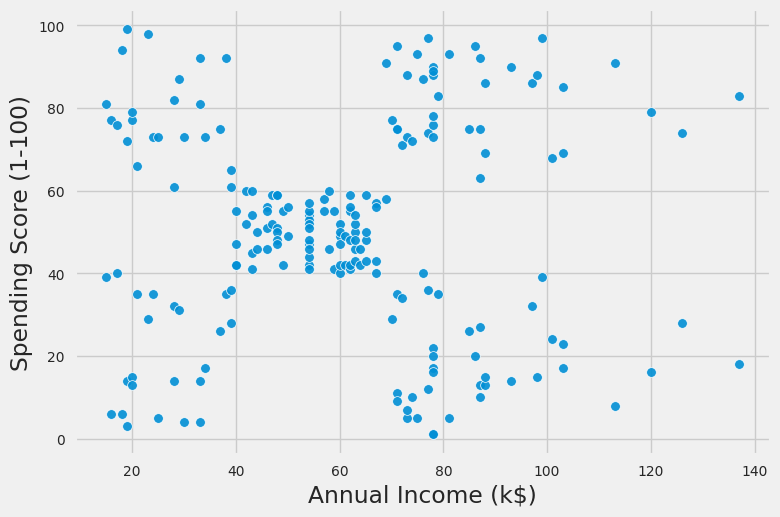

In [5]:
sns.scatterplot(data=dataset, x='Annual Income (k$)', y='Spending Score (1-100)', alpha=0.9)

## Centroid-based

### **K-Means**
The K-Means algorithm splits the given dataset into a predefined (K) number of clusters using a particular distance metric. The center of each cluster/group is called the centroid.

#### How does the K-Means algorithm work?

The most usual algorithm uses an iterative refinement technique. because of its ubiquity, it’s often called “the k-means algorithm”; it’s also mentioned as Lloyd’s algorithm, particularly within the computing community. The algorithm proceeds by alternating between two steps:

#### Assignment step:

Assign each observation to the cluster with the closest mean: that with the smallest amount squared Euclidean distance where each is assigned to exactly one, whether or not it may well be assigned to 2 or more of them.

#### Update step:

Recalculate means (centroids) for observations assigned to each cluster.

The algorithm has converged when the assignments no longer change. The algorithm is not guaranteed to find the optimal solution.

#### The way the K-means algorithm works is as follows:

- Specify the number of groups we wanna divide our samples referred to as K.
- Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.
- Keep iterating until there is no change to the centroids. i.e assignment of data points to groups isn’t changing.
- Compute the sum of the squared distance between data points and all centroids.
- Assign each data point to the closest group’s center point (centroid).
- Compute the centroids for the groups by taking the average of the all data points that belong to each cluster.

First lets perform some feature scaling. In this case, we’ll use the `StandardScaler` class. This class implements a type of feature scaling called standardization. Standardization scales, or shifts, the values for each numerical feature in your dataset so that the features have a mean of 0 and standard deviation of 1.

In [6]:
data_x = dataset.iloc[:, 3:5]
data_x.head()
x_array =  np.array(data_x)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_array)


After that, we’re going to choose the appropriate number of clusters using these methods :

### Elbow Method :
There’s a sweet spot where the SSE (sum of squares error) curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. The elbowpoint is the point where the rate of decrease of mean distance i.e. SSE will not change significantly with increase in number of clusters.

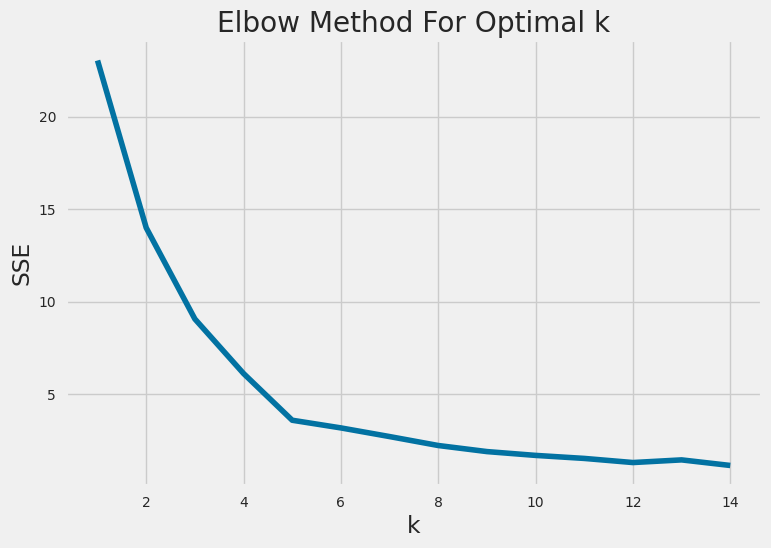

In [7]:
Sum_of_squared_distances =[]
K = range(1,15)
for k in K:
    km =KMeans(n_clusters =k)
    km =km.fit(x_scaled)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

You can also you Sklearn's `distortion` score to find the 'elbow' using this code:

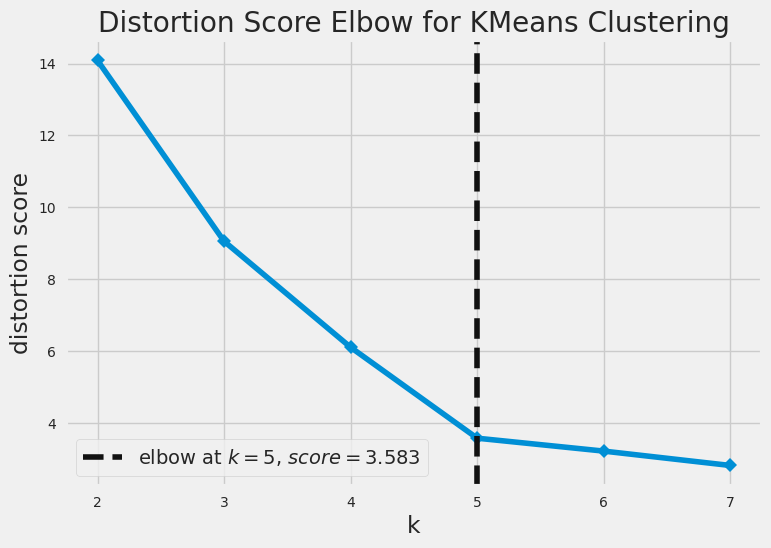

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
model = KMeans(random_state=123)
visualizer = KElbowVisualizer(model, k=(2,8), metric='distortion', timings=False)

visualizer.fit(x_scaled)
visualizer.poof()

In this example, the elbow is located at x=5.

### Silhouette Coefficient :
Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors: How close the data point is to other points in the cluster and how far away the data point is from points in other clusters. Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

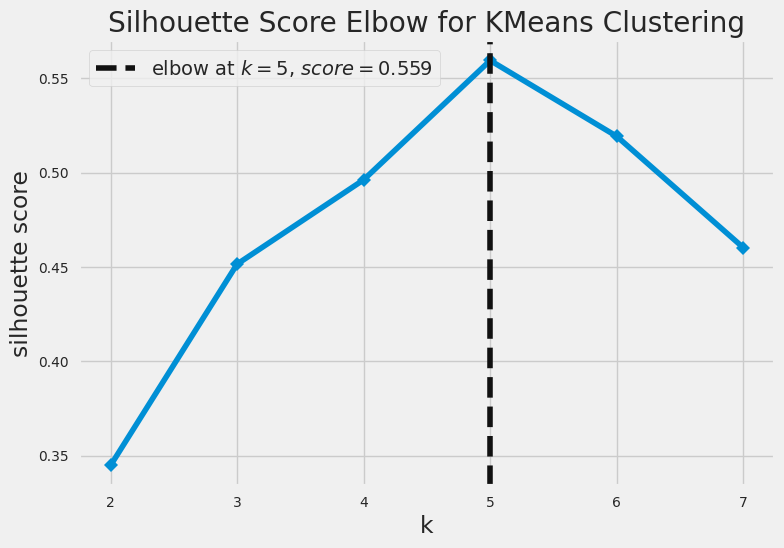

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [9]:
model = KMeans(random_state=123)
visualizer = KElbowVisualizer(model, k=(2,8), metric='silhouette', timings=False)

visualizer.fit(x_scaled)
visualizer.poof()

From the result above, we also got the score of 5.

So to sum up... distortion is taking into account ONLY the tightness of the cluster.  The closer all the points in a cluster are to the center of that same cluster, the lower the distortion.

Silhouette ALSO takes into account the distances between points of one cluster and the NEAREST cluster center. Meaning that in order to have a good silhouette score, clusters generally need to be tighter and farther from each other.

Here's an extreme example to illustrate the difference: If you have two clusters that are super tight, but the clusters are super close/right on top of each other, this would have a good distortion score (because the clusters are tight, nothing else is considered) but a bad silhouette score (because the clusters are right on top of each other, so the clusters themselves are hard to tell apart from one another).


After finding the optimal number of clusters, fit the K-Means clustering model to the dataset and then predict clusters for each of the data elements.

In [10]:
numerics = dataset[['Annual Income (k$)','Spending Score (1-100)']]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for i in numerics:
        scaler.fit(dataset[[i]])
        dataset[i] = scaler.transform(dataset[[i]])
km = KMeans(n_clusters=5)
y_predicted = km.fit_predict(dataset[['Annual Income (k$)', 'Spending Score (1-100)']])


After we get the cluster of each data, then we add the new column, by naming it as “Cluster”.

In [11]:
dataset["Cluster"] = y_predicted
dataset.head(10)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,0.000000,0.387755,0
1,2,Male,21,0.000000,0.816327,4
2,3,Female,20,0.008197,0.051020,0
3,4,Female,23,0.008197,0.775510,4
4,5,Female,31,0.016393,0.397959,0
5,6,Female,22,0.016393,0.765306,4
6,7,Female,35,0.024590,0.051020,0
7,8,Female,23,0.024590,0.948980,4
8,9,Male,64,0.032787,0.020408,0
9,10,Female,30,0.032787,0.724490,4


And the last step is visualizing the result of the clustering. For better representation, we need to give each of the clusters a unique colour and name.

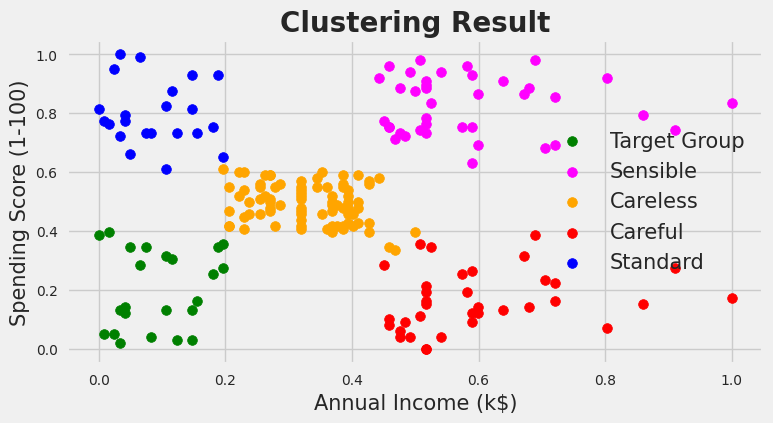

In [12]:
plt.figure(figsize=(8,4))
 # These clusters might need to be adjusted to match the right labels
df1 = dataset[dataset.Cluster==0]
df2 = dataset[dataset.Cluster==1]
df3 = dataset[dataset.Cluster==2]
df4 = dataset[dataset.Cluster==3]
df5 = dataset[dataset.Cluster==4]

plt.scatter(df1['Annual Income (k$)'],df1['Spending Score (1-100)'],color='green', label='Target Group')
plt.scatter(df2['Annual Income (k$)'],df2['Spending Score (1-100)'],color='magenta', label='Sensible')
plt.scatter(df3['Annual Income (k$)'],df3['Spending Score (1-100)'],color='orange', label='Careless')
plt.scatter(df4['Annual Income (k$)'],df4['Spending Score (1-100)'],color='red', label='Careful')
plt.scatter(df5['Annual Income (k$)'],df5['Spending Score (1-100)'],color='blue', label='Standard')
plt.title('Clustering Result', fontweight='bold',fontsize=20)
plt.xlabel('Annual Income (k$)',fontsize=15)
plt.ylabel('Spending Score (1-100)',fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

This is what the labels should be:

<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*SnocoHW9xppT7ItbUWDQ8A.png" width=500>


From the figure above, it can be seen that 5 clusters of customers have been formed. The clusters are:

- Target Group
- Sensible
- Careless
- Careful
- Standard


### Advantages of KMeans:

- It’s straightforward to implement.
- It’s scalable to massive datasets and also faster for large datasets.
- It adapts to new examples very frequently.

### Disadvantages of KMeans:

- May provide different clustering results on different runs as K-Means begins with random initialization of cluster centers.

- K-Means algorithm is sensitive to outliers.
- As the number of dimensions increases, scalability decreases.

- K-Means clustering is good at capturing the structure of the data if the clusters have a spherical-like shape. It always tries to construct a nice spherical shape around the centroid. This means that the minute the clusters have different geometric shapes, K-Means does a poor job clustering the data.
Even when the data points belong to the same cluster, K-Means doesn’t allow the data points far from one another, and they share the same cluster.  Let's take a look at that in comparison to GMMs in the next section.


## Distribution-based clustering algorithms
The clustering model that’s closely related to statistics is based on distribution models. Clusters can then be defined as objects that belong to the same distribution. This approach closely resembles how artificial datasets are generated, by sampling random objects from distribution.

While the theoretical aspects of these methods are pretty good, these models suffer from overfitting.

### **Gaussian mixture model**
Gaussian mixture model (GMM) is one of the types of distribution-based clustering. These clustering approaches assume data is composed of distributions, such as Gaussian distributions. In the figure below, the distribution-based algorithm clusters data into three Gaussian distributions. As the distance from the distribution increases, the probability that the point belongs to the distribution decreases.

GMM can be used to find clusters in the same way as K-Means. The probability that a point belongs to the distribution’s center decreases as the distance from the distribution center increases. The bands show a decrease in probability in the below image. Since GMM contains a probabilistic model under the hood, we can also find the probabilistic cluster assignment. When you don’t know the type of distribution in data, you should use a different algorithm.

Let’s see how GMM calculates probabilities and assigns it to data point:

<img alt="first image" src="https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Distribution-based-clustering.png?resize=609%2C380&ssl=1" width=500>



A GM is a function composed of several Gaussians, each identified by k ∈ {1,…, K}, where K is the number of clusters. Each Gaussian K in the mixture is comprised of following parameters: A mean μ that defines its center. A covariance Σ that defines its width. A mixing probability that defines how big or small or big the Gaussian function will be. These parameters can be seen in the below image:

<img alt="first image" src="https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Gaussian-mixture-model.png?resize=565%2C305&ssl=1" width=500>


Consider we need to assign K number of clusters, meaning K Gaussian distributions, with the mean and covariance values to be μ1, μ2, .. μk and Σ1, Σ2, .. Σk. There’s another parameter Πi which represents the density of distribution.

To find the covariance, mean, variance and weights of clusters, GMM uses the a similar technique to Kmeans.


#### Advantages of GMM

- One of the advantages of GMM over K-Means is that K-Means doesn’t account for variance (here, variance refers to the width of the bell-shaped curve) and GMM returns the probability that data points belong to each of K clusters.
- In case of overlapped clusters, all the above clustering algorithms fail to identify it as one cluster.
- GMM uses a probabilistic approach and provides probability for each data point that belongs to the clusters.

#### Disadvantages of GMM

- Mixture models are computationally expensive if the number of distributions is large or the dataset contains less observed data points.
- It needs large datasets and it’s hard to estimate the number of clusters.

To understand these differences between K-means and GMM, let's look a different example from [this](https://bobrupakroy.medium.com/gaussian-mixture-model-gmm-clustering-497c090a8316) article really quick:


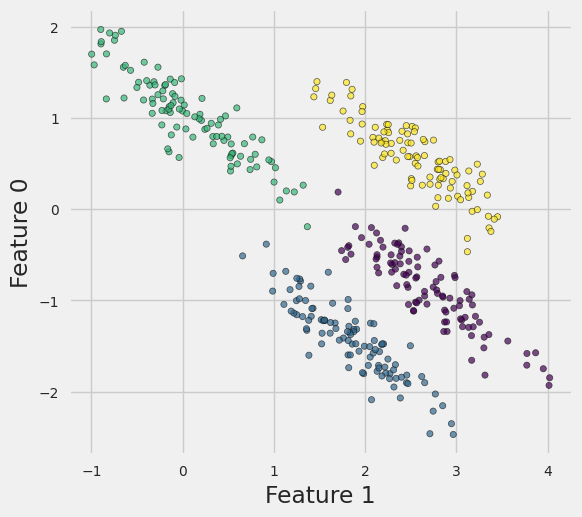

In [13]:
# generate Gaussian blobs
X, y_true = make_blobs(n_samples=400, n_features=2, centers=4,
                       cluster_std=0.6, random_state=0)
# stretch the data
# for reproducibility, we fix the random seed here
rng = np.random.RandomState(13)
X_stretch = np.dot(X, rng.randn(2, 2))

# plot data points with true labels
plt.figure(dpi=100)
scat = plt.scatter(X_stretch[:, 1], X_stretch[:, 0], c=y_true, s=20,
                   alpha=0.7, edgecolors='k', cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 0')
plt.gca().add_artist(plt.legend(*scat.legend_elements(),
                                title='True labels', bbox_to_anchor=(1.35, 1.)))
plt.gca().set_aspect(1)
plt.show()



#### K-Means

<ipython-input-14-376aa84e077e>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=cm.get_cmap('viridis', kmeans_stretch.n_clusters)(icenter))


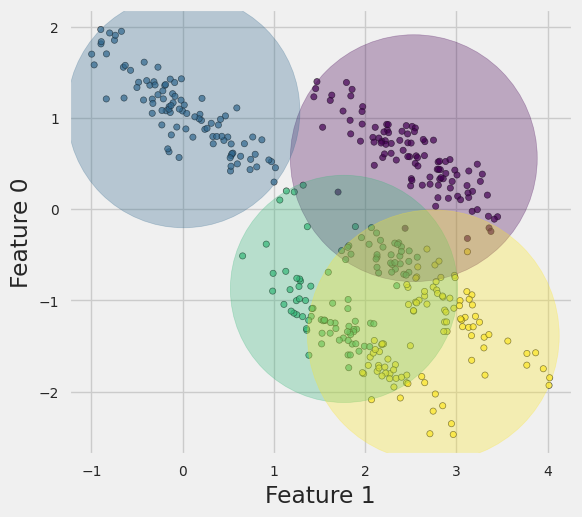

Homogeneity score = 0.698
Completeness score = 0.699
V-measure score = 0.698


In [14]:
from sklearn import metrics

# create k-means and fit
kmeans_stretch = KMeans(4, random_state=0).fit(X_stretch)

# make predictions
y_kmeans_stretch = kmeans_stretch.predict(X_stretch)

# plot data points with predicted labels
plt.figure(dpi=100)
scat = plt.scatter(X_stretch[:, 1], X_stretch[:, 0], c=y_kmeans_stretch, s=20,
                   alpha=0.7, edgecolors='k', cmap='viridis')
# add the range circles
for icenter, center in enumerate(kmeans_stretch.cluster_centers_):
    radius = np.max(np.linalg.norm(X_stretch[y_kmeans_stretch == icenter] - center, axis=1))
    circle = plt.Circle((center[1], center[0]), radius, alpha=.3,
                        color=cm.get_cmap('viridis', kmeans_stretch.n_clusters)(icenter))
    plt.gca().add_artist(circle)
plt.xlabel('Feature 1')
plt.ylabel('Feature 0')
plt.gca().add_artist(plt.legend(*scat.legend_elements(),
                                title='Clusters', bbox_to_anchor=(1.3, 1.)))
plt.gca().set_aspect(1)
plt.show()

# print scores
print('Homogeneity score = %.3f' % metrics.homogeneity_score(y_true, y_kmeans_stretch))
print('Completeness score = %.3f' % metrics.completeness_score(y_true, y_kmeans_stretch))
print('V-measure score = %.3f' % metrics.v_measure_score(y_true, y_kmeans_stretch))


### GMM

<ipython-input-15-9b18a0db5568>:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  add_ellipses(gmm, plt.gca(), cm.get_cmap('viridis', gmm.n_components))


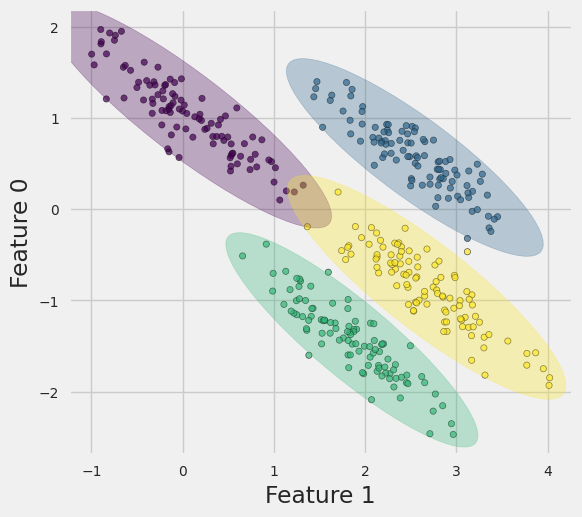

Homogeneity score = 0.980
Completeness score = 0.980
V-measure score = 0.980


In [15]:
from sklearn.mixture import GaussianMixture as GMM
import matplotlib as mpl
# create GMM and fit
gmm = GMM(n_components=4, n_init=20).fit(X_stretch)

# make predictions
y_gmm = gmm.predict(X_stretch)

# function to add ellipses of a GMM to a plot
def add_ellipses(gmm, ax, cmap, weight_threshold=None):
    for n in range(gmm.n_components):
        # check weight
        if weight_threshold is not None:
            if gmm.weights_[n] < weight_threshold:
                continue
        # get covariances
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        # compute ellipse geometry
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.degrees(np.arctan2(u[0], u[1]))
        v = 4. * np.sqrt(2.) * np.sqrt(v)

        ell = mpl.patches.Ellipse((gmm.means_[n, 1], gmm.means_[n, 0]), v[1], v[0], angle=90 + angle, color=cmap(n), alpha=.3)
        ax.add_artist(ell)

# plot data points with predicted labels
plt.figure(dpi=100)
scat = plt.scatter(X_stretch[:, 1], X_stretch[:, 0], c=y_gmm,
                   s=20, alpha=0.7, edgecolors='k', cmap='viridis')
add_ellipses(gmm, plt.gca(), cm.get_cmap('viridis', gmm.n_components))
plt.xlabel('Feature 1')
plt.ylabel('Feature 0')
plt.gca().add_artist(plt.legend(*scat.legend_elements(),
                                title='Clusters', bbox_to_anchor=(1.3, 1.)))
plt.gca().set_aspect(1)
plt.show()

# print scores
print('Homogeneity score = %.3f' % metrics.homogeneity_score(y_true, y_gmm))
print('Completeness score = %.3f' % metrics.completeness_score(y_true, y_gmm))
print('V-measure score = %.3f' % metrics.v_measure_score(y_true, y_gmm))

## Evaluating the clusters

We can evaluate qualitatively the goodness of the output. First of all, to verify that groups are actually meaningful, but also having a score can be the proxy to evaluate different models and choose the best one.

There are many different scores out there, each one with its pros and cons, but there are two main types of evaluation metrics for clustering,

1. Extrinsic Measures: These measures require ground truth labels, which may not be available in practice
2. Intrinsic Measures: These measures do not require ground truth labels (applicable to all unsupervised learning results)

Below is an explaination of some EXTRINSIC measures.  These worked for our previous example because we had a ground truth labels.

### Extrinisic measures:

#### V-measure or Normalised Mutual Information
This score can be interpretated as an average of other two measures: homogeneity and completeness.

#### Homogeneity
Homogeneity measures how much the sample in a cluster are similar.
When all samples in cluster k have the same label c, the homogeneity equals 1.
However, this can be a problem when 2 clusters share the same label...

For instance, here's an example of homogeneous clustering. All three clusters contains only one color (feature), in other words all the samples in the same cluster share their label.

<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*jD5KUKJQtNSaGZqpH-ShWw.png" width=500>

As you can see,  this situation is not optimal since orange samples are split into different clusters . In this example, a feature is not complete.

#### Completeness
Completeness although measures how much similar samples are put together by the clustering algorithm.

When all samples of kind c have been assigned to the same cluster k, the completeness equals 1.

Here's an example of a complete clustering. Each color is present only in one group. In this case all points with the same property have been classified together. Note that complete doesn’t imply homogeneous, in fact in each cluster there are multiple colors.


<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*zTgxaUg2szfkmSFPoofSuQ.png" width=500>

Now that we understand these two metrics, it is clear that an optimal algorithm would be able to obtain a partition which is both homogeneous and complete. In this case, all samples with a particular color are put together in a cluster and that cluster contains only them. If the algorithms was unsupervised it should be clear that with this output it has learnt correctly the features.


<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*7m0cc_DrCeZBDrcuyDwxqg.png" width=500>

Otherwise, the worst clustering possible is one which is neither homogeneous or complete. In this case each cluster contains multiple labels and each label is assigned to multiple clusters. In the case both the measures are zero.

<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*SyQh7gaG1qwbnrNpllUB4A.png" width=500>


Finally to obtain a measure of the goodness of our clustering algorithm we can consider the harmonic average between homogeneity and completeness and obtain the V-measure or Normalised Mutual Information.

### Intrinisic measures:

Used in cases where we do NOT have ground truth labels.  The **Elbow** method and **Silhoutte** method described above are examples of intrinisic measures.



Ok now that we've seen how an example of how Kmeans and GMM differ, lets look back at our Mall data and see how they can be similar.

In [16]:
from sklearn.mixture import GaussianMixture

# Scaling using StandardScaler
ss = StandardScaler()
ss.fit(numerics)
X = ss.transform(numerics)
#  Perform clsutering
gm = GaussianMixture(
                     n_components = 5,
                     n_init = 10,
                     max_iter = 100)
# Train the algorithm
gm.fit(X)
# Cluster labels
numerics["Cluster"] = gm.predict(X)
numerics.head(10)

<ipython-input-16-dfddc0489f55>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerics["Cluster"] = gm.predict(X)


,Annual Income (k$),Spending Score (1-100),Cluster
0,15,39,2
1,15,81,4
2,16,6,2
3,16,77,4
4,17,40,2
5,17,76,4
6,18,6,2
7,18,94,4
8,19,3,2
9,19,72,4


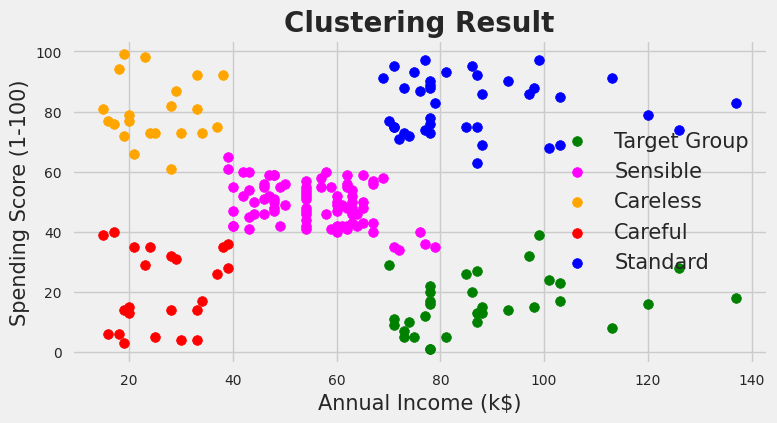

In [17]:
plt.figure(figsize=(8,4))
df1 = numerics[numerics.Cluster==1]
df2 = numerics[numerics.Cluster==0]
df3 = numerics[numerics.Cluster==4]
df4 = numerics[numerics.Cluster==2]
df5 = numerics[numerics.Cluster==3]
plt.scatter(df1['Annual Income (k$)'],df1['Spending Score (1-100)'],color='green', label='Target Group')
plt.scatter(df2['Annual Income (k$)'],df2['Spending Score (1-100)'],color='magenta', label='Sensible')
plt.scatter(df3['Annual Income (k$)'],df3['Spending Score (1-100)'],color='orange', label='Careless')
plt.scatter(df4['Annual Income (k$)'],df4['Spending Score (1-100)'],color='red', label='Careful')
plt.scatter(df5['Annual Income (k$)'],df5['Spending Score (1-100)'],color='blue', label='Standard')
plt.title('Clustering Result', fontweight='bold',fontsize=20)
plt.xlabel('Annual Income (k$)',fontsize=15)
plt.ylabel('Spending Score (1-100)',fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

Again, the labels are probably off here.

Just for the sake of comprehension, there are 2 other ways to assess models: Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).  We will briefly talk about them here, but know that we'll do a deeper dive into these metrics later.  

 AIC and BIC are both model selection criteria that are used to compare different models and choose the one that best fits the data. The goal of both AIC and BIC is to balance the goodness-of-fit of the model with its complexity, in order to avoid overfitting or underfitting.

The main difference between AIC and BIC is how they weigh the trade-off between goodness-of-fit and complexity.

AIC and BIC are fundamentally based on the likelihood function, which is a core component of probabilistic models so we can use these measures to assess our GMM.  

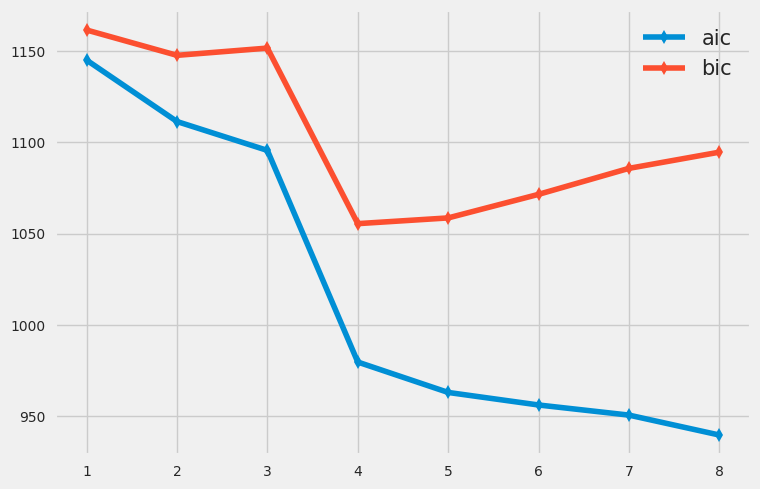

In [20]:
bic = []
aic = []
for i in range(8):
    gm = GaussianMixture(
                     n_components = i+1,
                     n_init = 10,
                     max_iter = 100)
    gm.fit(X)
    bic.append(gm.bic(X))
    aic.append(gm.aic(X))

# Look at the plots

fig = plt.figure()
plt.plot([1,2,3,4,5,6,7,8], aic, marker = "d", label = 'aic')
plt.plot([1,2,3,4,5,6,7,8], bic, marker = "d", label = 'bic')
plt.legend(fontsize=15)
plt.show()

### GMM vs K-means clustering algorithm and why K-means is so popular

- GMM uses probability distribution and K-means uses distance metrics to compute the difference between data points to segregate the data into different clusters.
- GMM is a soft clustering algorithm in a sense that each data point is assigned to a cluster with some degrees of uncertainty e.g. You can see in the above image that some data points have a very high probability to belong to one specific gaussian, while some points are in between two gaussians. This means that a data point can belong to more than one cluster i.e distributed in two clusters with 70/30 ratio.
- K-means may not perform well while finding clusters of different sizes, shapes, and densities. E.g., clustering of elliptically distributed data might fail with K-means, as it’s more suited for circular distribution. In such cases, it makes sense to go ahead with GMM.

However, K-means requires much less time to discover the group for the data points than GMM does for gaussian components. K-means is popular because it is easy to apply and converge quickly. It can be used without any assumptions about the data engineering process. Due to K-means simplicity and efficiency, it is also used for image segmentation and it gives competitive results to much more complex deep neural network algorithms.

## Density-based clustering algorithms

Density-based clustering connects areas of high example density into clusters. This allows for arbitrary shape distributions as long as dense regions are connected. With the higher dimension data and data of varying densities, these algorithms run into issues. By design, these algorithms don’t assign outliers to clusters.


### DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density based clustering algorithm. The main concept of DBSCAN algorithm is to locate regions of high density that are separated from one another by regions of low density.

DBSCAN can identify clusters in a large spatial dataset by looking at the local density of corresponding elements. The advantage of the DBSCAN algorithm over the K-Means algorithm, is that the DBSCAN can determine which data points are noise or outliers. DBSCAN can identify points that are not part of any cluster (very useful as outliers detector). But it slower than agglomerative clustering and k-means, but still scales to relatively large datasets.

There are two parameters in DBSCAN: `minPoints` and `eps` :

- `eps`: specifies how close points should be to each other to be considered a part of a cluster. It means that if the distance between two points is lower or equal to this value (eps), these points are considered to be neighbors.
- `minPoints`: the minimum number of data points to form a dense region/ cluster. For example, if we set the minPoints parameter as 5, then we need at least 5 points to form a dense region.

<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1238/format:webp/0*A_fRorTS3Oquu1nT.png" width=500>

Based on the two parameters, the points are classified as Core point, Border point and Noise point.

<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*-Oz9o5YlRtTzvKQn.png" width=500>

- Core Point

 -  A point is a core point if it has more than a specified number of `minPoints` within `eps` radius around it.
 - Core Point always belongs in a dense region.

- Border Point

   - A point is a border point if it has fewer than `minPoints` within `eps`, but is in the neighborhood of a core point.

- Noise Point

  - A noise point is any point that is not a core point or a border point.

Before we go through the DBScan algorithm, we should understand about the Density Edge and the Density Connected Points:


<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*-zKLuElO6CQqkR1i.png" width=500>

### Steps of DBSCAN Algorithm:
1. The algorithm starts with an arbitrary point which has not been visited and its neighborhood information is retrieved from the epsparameter.
2. If this point contains `minPoints` within `eps` neighborhood, cluster formation starts. Otherwise the point is labeled as noise. This point can be later found within the epsneighborhood of a different point and, thus can be made a part of the cluster.
3. If a point is found to be a core point then the points within the eps neighborhood is also part of the cluster. So all the points found within eps neighborhood are added, along with their own eps neighborhood, if they are also core points.
4. The above process continues until the density-connected cluster is completely found.
The process restarts with a new point which can be a part of a new cluster or labeled as noise.

### Determining the parameters:

#### How to choose the `minPoints`?

- Remove the outlier
- Take the `minPoints` to be greater or equal to the dimensionality (d) of our dataset
- Take the `minPoints` twice of the dimensionality of data
- If the dataset is noisier, choose a larger value of min Points
Choosing the min Points process is creally depends a lot on domain knowledge

#### How to determine eps?

I.e. choose a `minPoints = 4`, for each point p, we’ll compute “d”, where d = distance from p to the 4th nearest neighbor of p. If d is high, then the chance of p is noisy is also high.

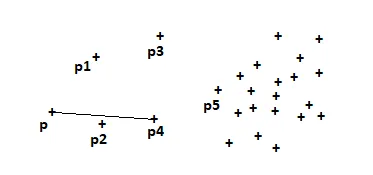

For each point of the dataset, we’ll have our d’s. Then, we’ll sort all d’s in increasing order. Now, we’ll plot the sorted point index and d’s with elbow or Knee method.

Check out the example below to get an intuition on how DBSCAN works.

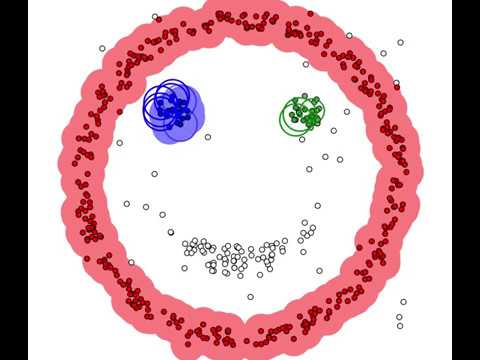

In [21]:
from IPython.display import YouTubeVideo
YouTubeVideo("h53WMIImUuc", width=400)

### Advantages of DBSCAN:

- It doesn’t require a predefined number of clusters.
- It also identifies noise and outliers.
- Arbitrarily sized and shaped clusters are found pretty well by the algorithm.
- The algorithm is better than K-Means when it comes to oddly shaped data.

### Disadvantages of DBSCAN:

- It expects some kind of density drop to detect cluster borders.
- DBSCAN connects areas of high example density.



In [22]:
from sklearn.cluster import DBSCAN
import sklearn.utils

In [23]:
df = dataset
Clus_dataSet = df[['Annual Income (k$)','Spending Score (1-100)']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = np.array(Clus_dataSet, dtype=np.float64)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)
# Compute DBSCAN
db = DBSCAN(eps=0.4, min_samples=5).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df['Clus_Db']=labels
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))
# A sample of clusters
print(df[['Annual Income (k$)','Spending Score (1-100)']].head())
# Number of Labels
print("number of labels: ", set(labels))

   Annual Income (k$)  Spending Score (1-100)
0            0.000000                0.387755
1            0.000000                0.816327
2            0.008197                0.051020
3            0.008197                0.775510
4            0.016393                0.397959
number of labels:  {0, 1, 2, 3, -1}


Let’s visualize the clusters determined by DBSCAN, using this code:

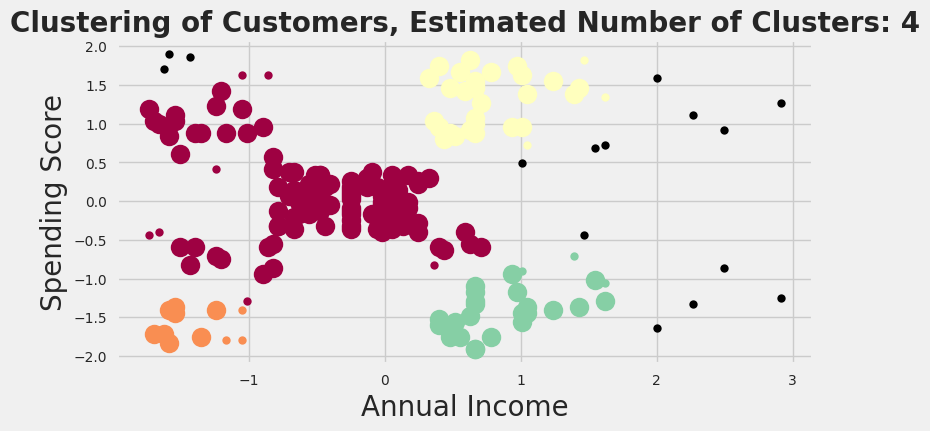

number of noise(s):  15


In [25]:
# Black removed and is used for noise instead
plt.figure(figsize=(8,4))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:

        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = Clus_dataSet[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)
    xy = Clus_dataSet[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)
plt.title('Clustering of Customers, Estimated Number of Clusters: %d' % realClusterNum, fontweight='bold',fontsize=20)
plt.xlabel('Annual Income',fontsize=20)
plt.ylabel('Spending Score',fontsize=20)
plt.legend(fontsize=20)
plt.show()
n_noise_ = list(labels).count(-1)
print('number of noise(s): ', n_noise_)

From this part of DBSCAN implementation, we can conclude that DBSCAN performed really well at detecting outliers which would not be easy with K-Means or GMM techniques.
However, similar to GMM, DBSCAN will also perform well with arbitrarily shaped clusters.  




## Hierarchical clustering algorithms (connectivity-based clustering)

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. There are two types of hierarchical clustering, Agglomerative and Divisive.


<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*fLxcCMLdff3wPdav.png" width=500>


- Divisive Clustering : the type of hierarchical clustering that uses a top-down approach to make clusters. It uses an approach of the partitioning of 2 least similiar clusters and repeats this step until there is only one cluster. Divisive clustering is not commonly used in real life.
- Agglomerative Clustering : the type of hierarchical clustering which uses a bottom-up approach to make clusters. It uses an approach of the partitioning 2 most similiar clusters and repeats this step until there is only one cluster. These steps are how the agglomerative hierarchical clustering works:

**Agglomerative hierarchical clustering (AHC)**

In this section, we'll explore the AHC algorithm.

For a set of N observations to be clustered:

1. Start assigning each observation as a single point cluster, so that if we have N observations, we have N clusters, each containing just one observation.
2. Find the closest (most similar) pair of clusters and make them into one cluster, we now have N-1 clusters.
3. Find the two closest clusters and make them to one cluster.  We now have N-2 clusters. This can be done using agglomerative clustering linkage techniques (see below).
4. Repeat steps 2 and 3 until all observations are clustered into one single cluster of size N.

<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*ohcYAJNni32TIROS" width=500>


Before performing the clustering, it is required to determine the proximity matrix containing the distance between each point using a distance function. The following methods differ in how the distance between each cluster is measured (you don't need to know these specifically, just know there are different ways to calculate this):


<img alt="first image" src="https://miro.medium.com/v2/resize:fit:1218/format:webp/0*xFGO1Ua2WmXQAxo5.png" width=500>


So to sum it up:
Hierarchical clustering starts by treating each observation as a separate cluster. Then, it repeatedly executes the following steps:

- Identify the two clusters that are closest together
- Merge the two most similiar clusters

This continues until all the clusters are merged together. How do we decide the number of clusters? To get the number of clusters for hierarchical clustering, we make use a Dendrogram.

#### Dendrograms

Dendrograms are tree diagrams frequently used to illustrate the arrangement of the clusters produced by hierarchical clustering. It indicates the **similarity** and the **order** in which the cluster was formed.  


The image below gives an idea of the hierarchical clustering approach.

<img alt="first image" src="https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Hierarchical-clustering.png?resize=718%2C323&ssl=1" width=500>

Ok lets see what our mall data will look like using this clustering approach.


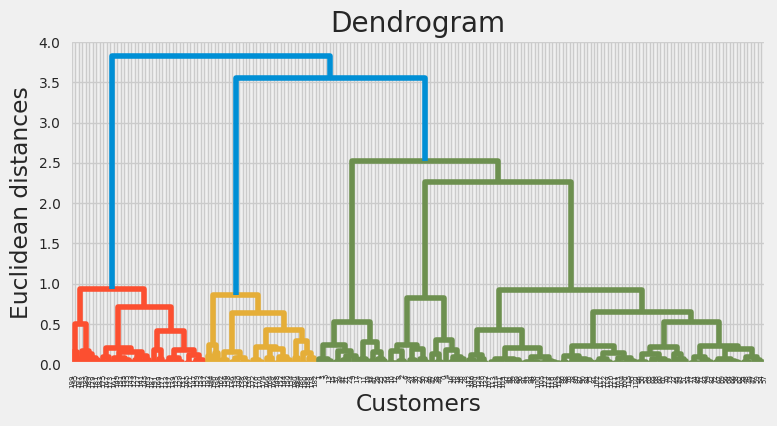

In [26]:
X = df.iloc[:,[3,4]].values
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
plt.figure(figsize=(8,4))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
#plt.grid(True)
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.show()


We can clearly visualize the steps of hierarchical clustering. More the distance of the vertical lines in the dendrogram, more the distance between those clusters.

And then, we can set a threshold distance and draw a horizontal line. We try to set the threshold in such a way that it cuts the tallest vertical line. From that dendrogram above we can set the threshold as = 200 and we can see from the output below : the horizontal line crossing 5 vertical lines.

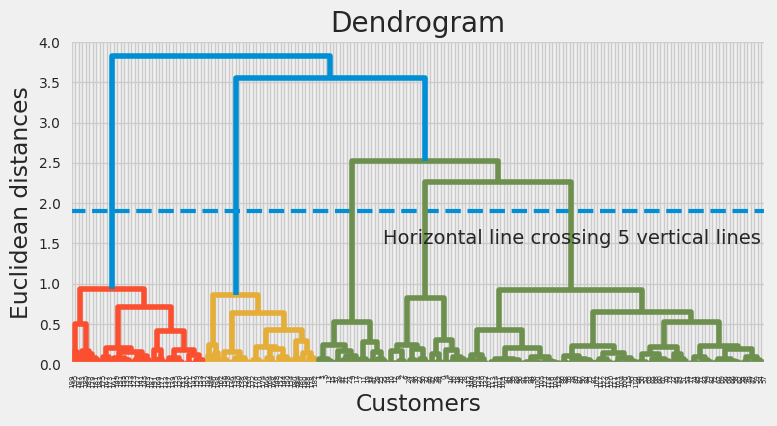

In [27]:
plt.figure(figsize=(8,4))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.hlines(y=1.90,xmin=0,xmax=2000,lw=3,linestyles='--')
plt.text(x=900,y=1.50,s='Horizontal line crossing 5 vertical lines',fontsize=14)
# #plt.grid(True)
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.show()

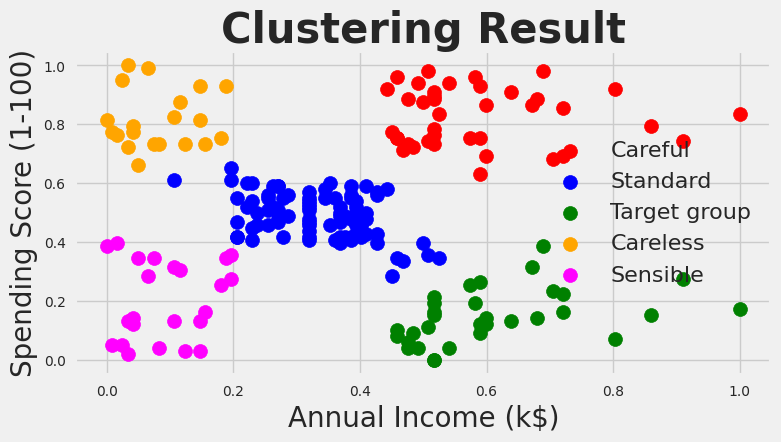

In [28]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, metric = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)
plt.figure(figsize=(8,4))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Careful')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Standard')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Target group')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'orange', label = 'Careless')
plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Sensible')
plt.title('Clustering Result', fontweight='bold',fontsize=30)
plt.xlabel('Annual Income (k$)',fontsize=20)
plt.ylabel('Spending Score (1-100)',fontsize=20)
plt.legend(fontsize=16)
plt.grid(True)
# plt.axhspan(ymin=0,ymax=1,xmin=0.4,xmax=0.96,alpha=0.3,color='yellow')
plt.show()

### Advantages of AHC:

- AHC is easy to implement, it can also provide object ordering, which can be informative for the display.
- We don’t have to pre-specify the number of clusters. It’s easy to decide the number of clusters by cutting the dendrogram at the specific level.
- In the AHC approach smaller clusters will be created, which may uncover similarities in data.

### Disadvantages of AHC:

- The objects which are grouped wrongly in any steps in the beginning can’t be undone.
- Hierarchical clustering algorithms don’t provide unique partitioning of the dataset, but they give a hierarchy from which clusters can be chosen.
- They don’t handle outliers well. Whenever outliers are found, they will end up as a new cluster, or sometimes result in merging with other clusters.
- Hierarchical clustering is computationally expensive, especially for large datasets, as it requires calculating and storing the distances between all pairs of data points.

The Agglomerative Hierarchical Cluster Algorithm is a form of bottom-up clustering, where each data point is assigned to a cluster. Those clusters then get connected together. Similar clusters are merged at each iteration until all the data points are part of one big root cluster.

Great job!  If you can answer the questions... you're set for the quiz on this topic!